### Ideas:
- Try KMeans and DBSCAN
- For each algorithm perform selection on the dataset and plot the results (use PCA or PACMAP to visualize clusters)
- Inject errors
- Try median/mode and MICE with K-NN with median/mode

### Clustering code (for abalone.csv)

In [23]:
import pandas as pd
import numpy as np
#from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer


cluster_colors = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']

In [24]:
X = pd.read_csv("../datasets/abalone.csv")

# Get one hot encoding of column 0
one_hot = pd.get_dummies(X['0'])
# Drop column 0 as it is now encoded
df = X.drop('0',axis = 1)

X = df.join(one_hot)
X

,1,2,3,4,5,6,7,F,I,M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,0,1,0
...,...,...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,1,0,0
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,0,0,1
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,0,0,1
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,1,0,0


#### Searching the best value for k with the elbow method
We search for an elbow in the distortion score for different values of k

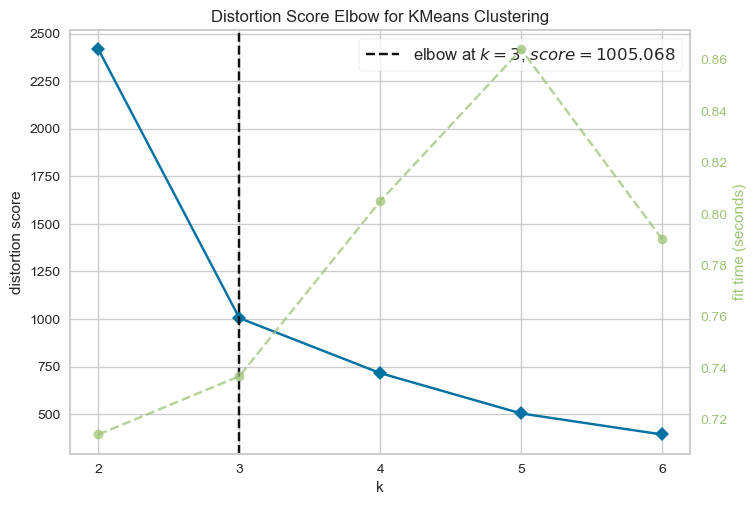

In [25]:
fig, ax = plt.subplots()

visualizer = KElbowVisualizer(KMeans(), k=(2,7),ax=ax)
visualizer.fit(X)
ax.set_xticks(range(2,7))

visualizer.show()
plt.show()

#### Searching the best value for k with silhouette scores
We search for the value of k that maximises the silhouette score of the found clusters

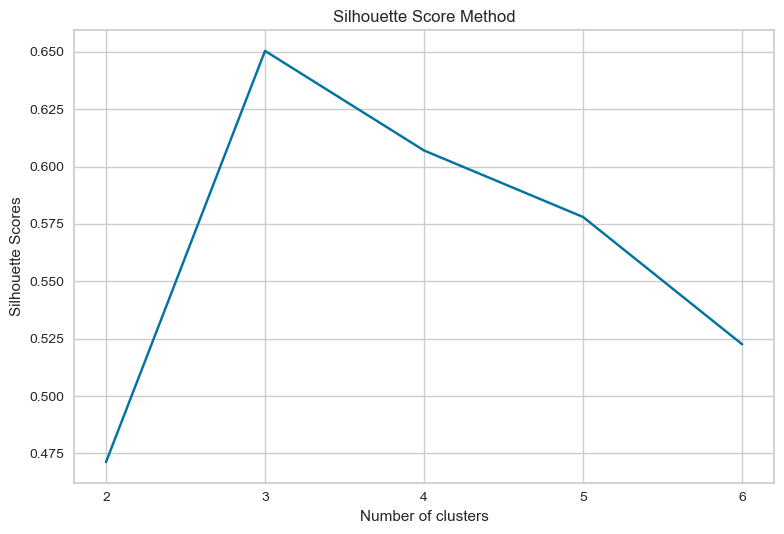

In [26]:
silhouette_scores = []
for k in range(2, 7):
    km = KMeans(n_clusters=k, 
                max_iter=300, 
                tol=1e-04, 
                init='k-means++', 
                n_init=10, 
                random_state=42, 
                algorithm='lloyd')
    km.fit(X)
    silhouette_scores.append(silhouette_score(X, km.labels_))

fig, ax = plt.subplots()
ax.plot(range(2, 7), silhouette_scores, 'bx-')
ax.set_title('Silhouette Score Method')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette Scores')
plt.xticks(range(2, 7))
plt.tight_layout()
plt.show()

#### Searching the best value for k with silhouette analysis
Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

We search for the value of k that generates clusters that are similar in size (width of the silhouette) and also in the distances between them (we want them to have values near +1)

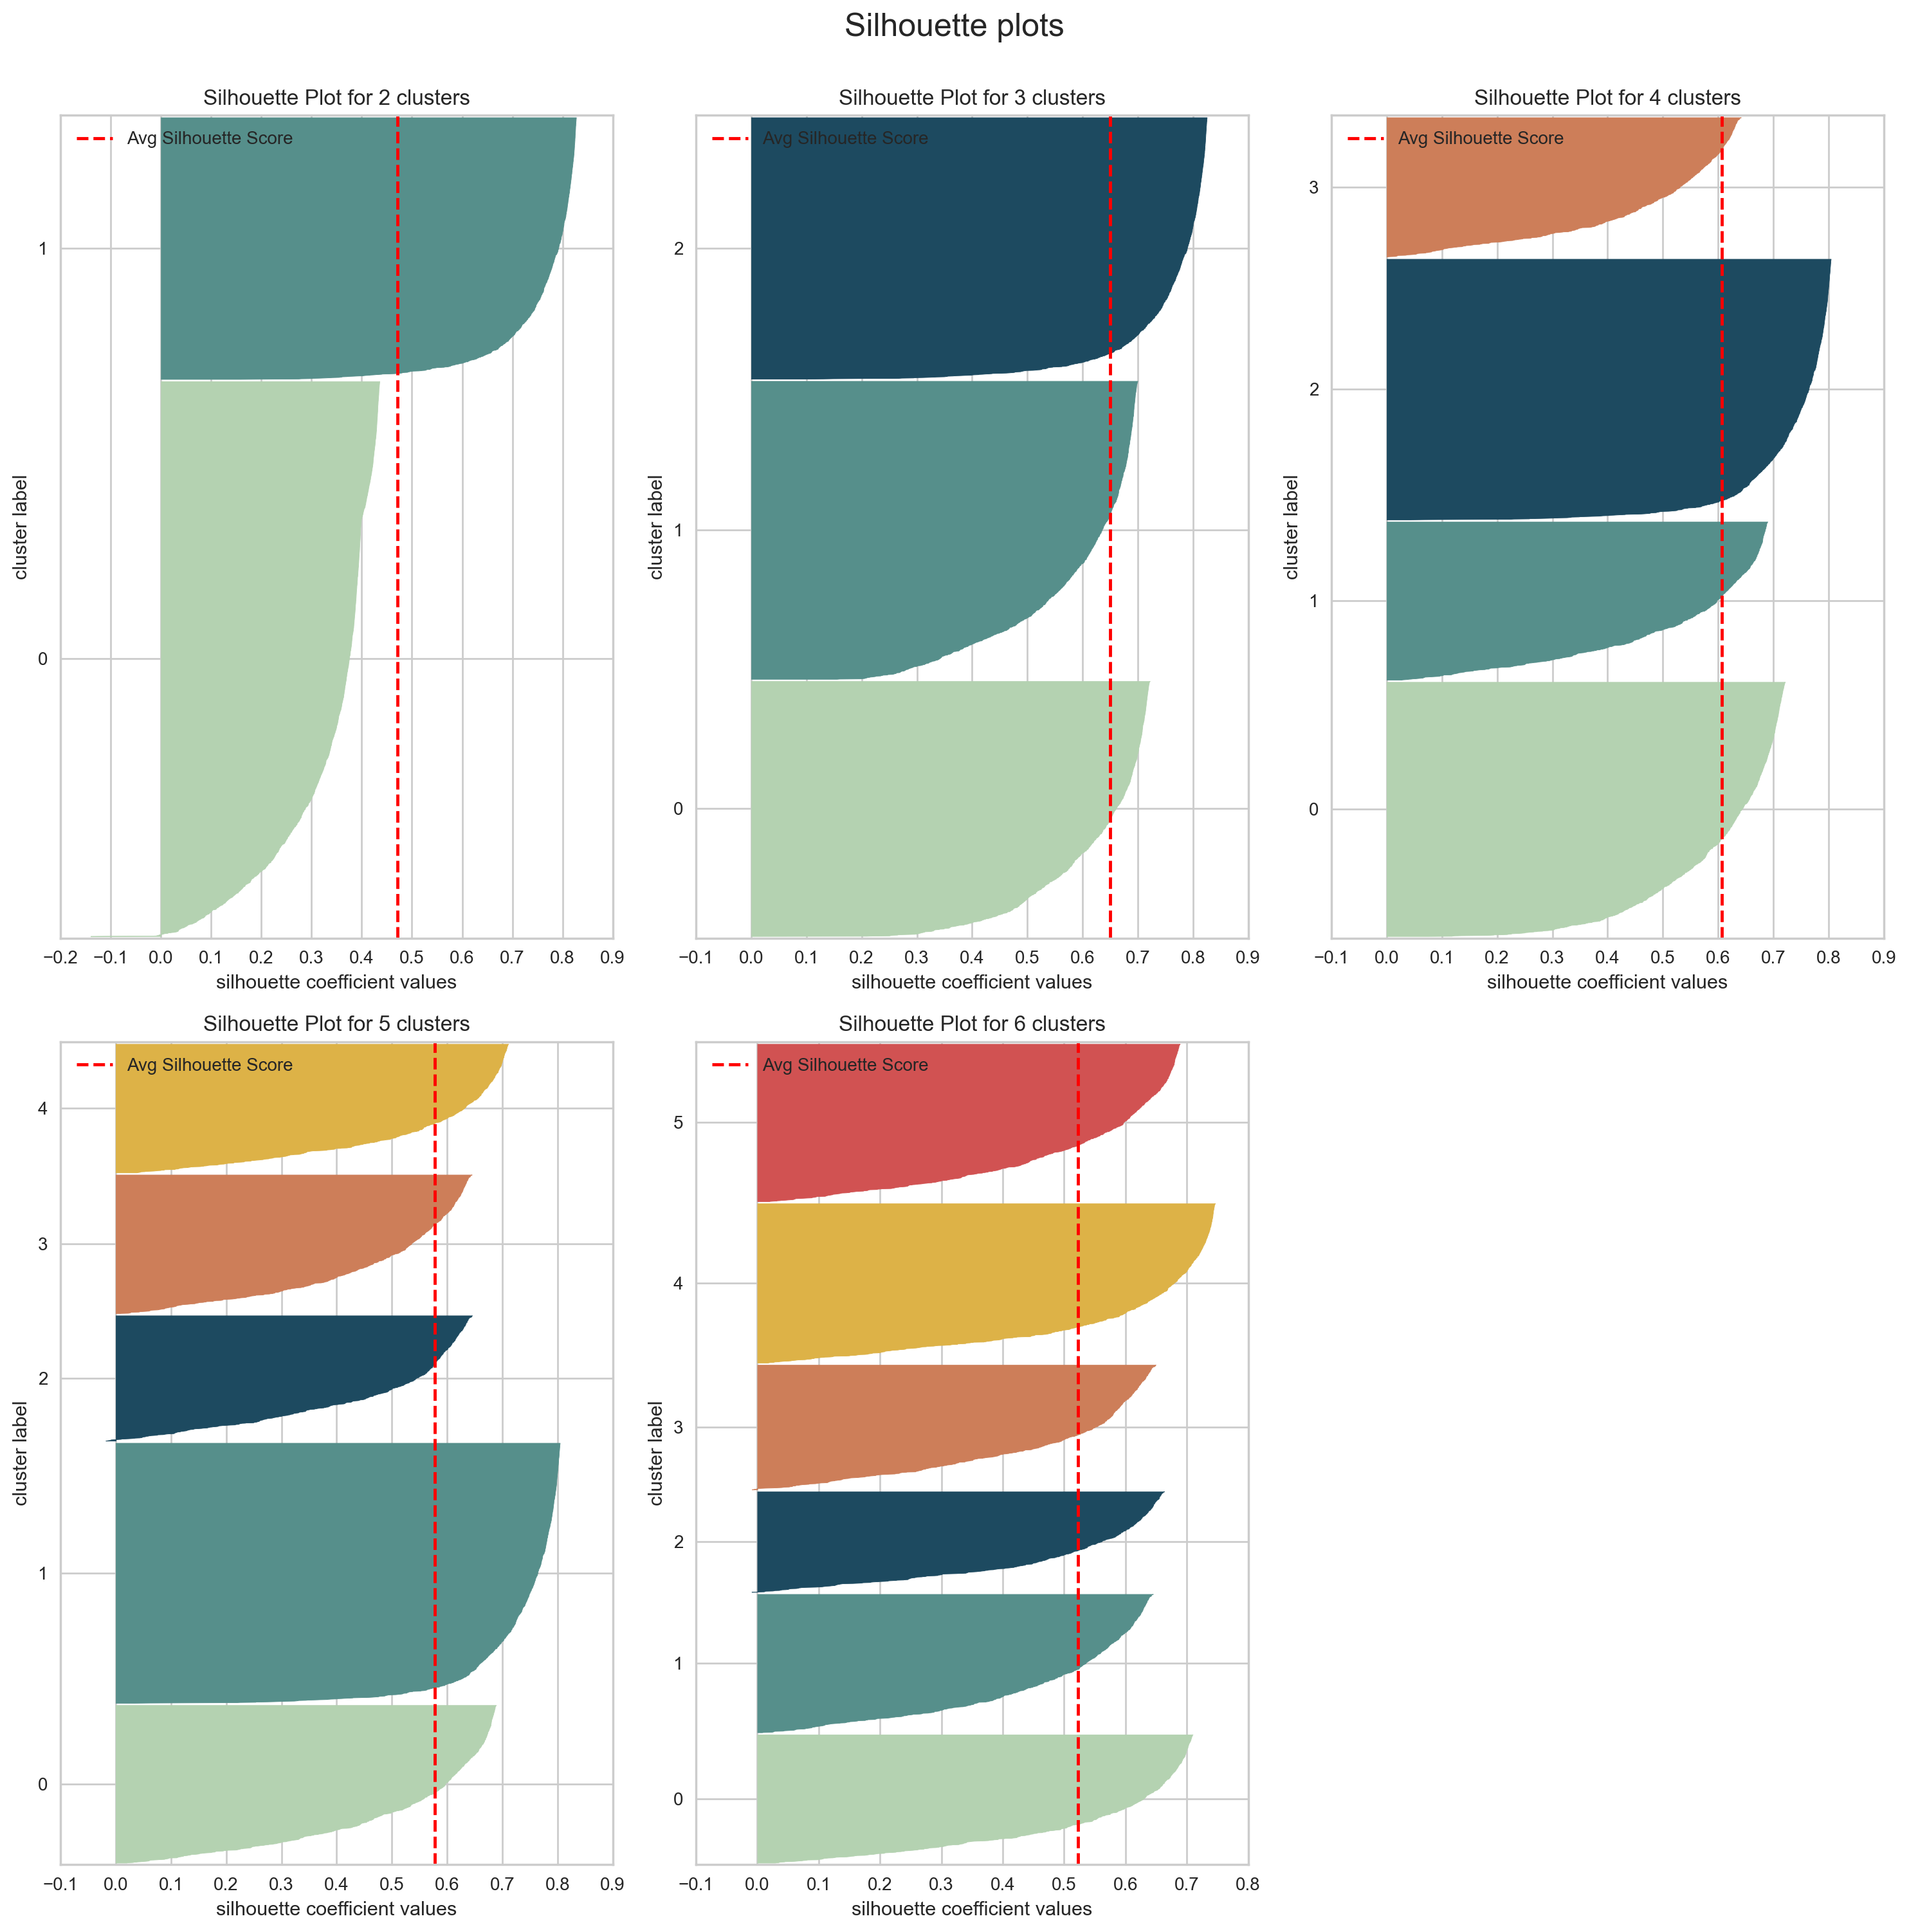

In [28]:
def silhouette_plot(X, model, ax, colors):
    y_lower = 10
    y_tick_pos_ = []
    sh_samples = silhouette_samples(X, model.labels_)
    sh_score = silhouette_score(X, model.labels_)
    
    for idx in range(model.n_clusters):
        values = sh_samples[model.labels_ == idx]
        values.sort()
        size = values.shape[0]
        y_upper = y_lower + size
        ax.fill_betweenx(np.arange(y_lower, y_upper),0,values,
                         facecolor=colors[idx],edgecolor=colors[idx]
        )
        y_tick_pos_.append(y_lower + 0.5 * size)
        y_lower = y_upper + 10

    ax.axvline(x=sh_score, color="red", linestyle="--", label="Avg Silhouette Score")
    ax.set_title("Silhouette Plot for {} clusters".format(model.n_clusters))
    l_xlim = max(-1, min(-0.1, round(min(sh_samples) - 0.1, 1)))
    u_xlim = min(1, round(max(sh_samples) + 0.1, 1))
    ax.set_xlim([l_xlim, u_xlim])
    ax.set_ylim([0, X.shape[0] + (model.n_clusters + 1) * 10])
    ax.set_xlabel("silhouette coefficient values")
    ax.set_ylabel("cluster label")
    ax.set_yticks(y_tick_pos_)
    ax.set_yticklabels(str(idx) for idx in range(model.n_clusters))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.legend(loc="best")
    return ax


# Plot for multiple ks
k_max = 6
ncols = 3
# calculate number of rows
nrows = k_max // ncols + (k_max % ncols > 0)
# set figure size
fig = plt.figure(figsize=(15,15), dpi=200)

for k in range(2,k_max+1):
    
    # Apply clustering for k clusters
    km = KMeans(n_clusters=k, 
                max_iter=300, 
                tol=1e-04, 
                init='k-means++', 
                n_init=10, 
                random_state=42, 
                algorithm='lloyd')

    km_fit = km.fit(X)
    
    # create chart
    ax = plt.subplot(nrows, ncols, k-1)
    silhouette_plot(X, km_fit,ax, cluster_colors)

fig.suptitle("Silhouette plots", fontsize=18, y=1)
plt.tight_layout()
plt.show()

#### Final decision
We're going for k=3

In [30]:
km = KMeans(n_clusters=3, 
            max_iter=300, 
            tol=1e-04, 
            init='k-means++', 
            n_init=10, 
            random_state=42, 
            algorithm='lloyd')

km_fit = km.fit(X)